In [1]:
import numpy as np
import h5py, os, imageio
import matplotlib.pyplot as plt
from util_Matt import Util
from scipy.optimize import curve_fit


In [2]:
from Module_diagnostic_functions import *

In [3]:
###### read data
E = 10000
# powers = ['1W', '3W', '10W', '20W', '40W']
powers = ['40W']

dir_out = 'output/'
dir_ev = dir_out+'{}keV/'.format(np.int(E/1e3))



mirror_x = []
mirror_y = []
mirror_h = []

axis_x = []
axis_y = []
axis_z = []

slice_x = []
slice_y = []
total_intensity = []

for power in powers:
    fname_profile = '{}_Si111'.format(power)
    # fname_profile = '{}'.format(power)
    dir_plot = dir_ev+'{}/'.format(fname_profile)
    fname = '{}_heat_bump.h5'.format(fname_profile)

    with h5py.File(dir_plot+fname, 'r') as f:
        mirror_x.append(f['lens_x'][:])
        mirror_y.append(f['lens_y'][:])
        mirror_h.append(f['lens_h'][:])
        axis_x.append(f['axis_x'][:])
        axis_y.append(f['axis_y'][:])
        axis_z.append(f['axis_z'][:])
#         slice_x.append(f['slice_x'][:])
#         slice_y.append(f['slice_y'][:])
#         total_intensity.append(f['intensity'][:])
        slice_x.append(f['projection_x'][:])
        slice_y.append(f['projection_y'][:])

# for i in range(n_img):
#     slice_x[i] = np.divide(slice_x[i], total_intensity[i][:,None])



<ipython-input-3-e51a03918db1>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dir_ev = dir_out+'{}keV/'.format(np.int(E/1e3))


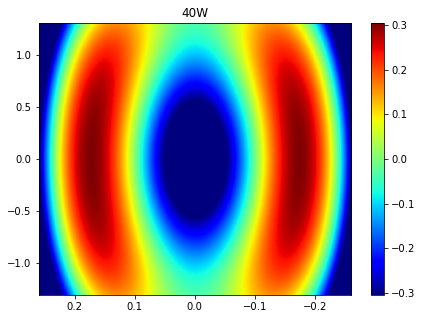

In [4]:
###### Mirror profiles
n_img = len(powers)

for i in range(n_img):
    mirror_h[i]-= np.mean(mirror_h[i])

plt.figure(figsize=(5*n_img+2,5))
for i in range(n_img):
    plt.subplot(1,n_img,int(i+1))
    plt.imshow(mirror_h[i].T*1e9, cmap='jet',
              extent=[np.max(mirror_y)*1e3, np.min(mirror_y)*1e3, np.min(mirror_x)*1e3, np.max(mirror_x)*1e3])
    plt.clim([-np.max(mirror_h)*1e9, np.max(mirror_h)*1e9])
    plt.title(powers[i])
    plt.colorbar()
    plt.axis('tight')

if n_img == 1:
    plt.savefig(dir_ev+'heat_bump_profile_{}.png'.format(fname_profile), transparent=True)
else:
    plt.savefig(dir_ev+'heat_bump_profiles.png', transparent=True)

### To-do:
Subtract the 2nd order term in 2D polynomial fit for the profile and then calculate the theoretical Strehl ratio.
Try adding a square aperture at lens and play around with the aperture size to see how focus is optimized.

<ipython-input-5-71a1b89bc4e6>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xnew_mir*1e3, ynew_mir*1e3, OPD*1e9,cmap='jet')


RMS height error: 105.47pm, Strehl ratio: 0.001


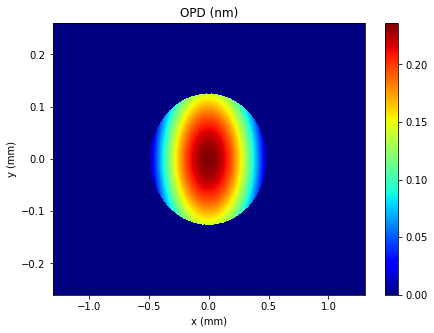

In [5]:
###### Strehl ratio
theta = np.deg2rad(15)
fwhm_on_mir = 250.81e-6    # this should be different for various photon energies etc...
labels = []    # holder for RMS height errors

plt.figure(figsize=(n_img*5+2,5))
for i in range(n_img):
    xnew_mir = mirror_x[i]
    ynew_mir = mirror_y[i]
    h_new = mirror_h[i]
    E = 9481
    wavelength = 4.135667696e-15 * 299792458/E

    # choose aperture
    index_fwhm = ( (xnew_mir*np.sin(theta))**2 + ynew_mir**2 )<= (fwhm_on_mir/2)**2
    OPD = -h_new * 2 * np.sin(theta); OPD[index_fwhm==False] = 0
    
    plt.subplot(1,n_img,i+1)
#     plt.imshow(OPD*1e9, cmap='jet',
#               extent = [xnew_mir.min()*1e3, xnew_mir.max()*1e3, ynew_mir.max()*1e3, ynew_mir.min()*1e3])
    plt.pcolormesh(xnew_mir*1e3, ynew_mir*1e3, OPD*1e9,cmap='jet')
    plt.axis('tight'); plt.colorbar()
    plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.title('OPD (nm)')
    d_phase = 2*np.pi*OPD/wavelength
#     S = np.abs(np.mean(np.exp(1j*d_phase[index_fwhm])))**2
    S = np.exp(-np.std(d_phase[index_fwhm])**2)
    h_error = round(np.std(h_new[index_fwhm])*1e12,2)
    label = '{}pm'.format(h_error)
    labels.append(label)
    print('RMS height error: {}pm,'.format(h_error), 'Strehl ratio:', round(S,4))
    


<ipython-input-6-976068a1e05f>:30: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img_x), cmap='jet',
<ipython-input-6-976068a1e05f>:35: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img_y), cmap='jet',


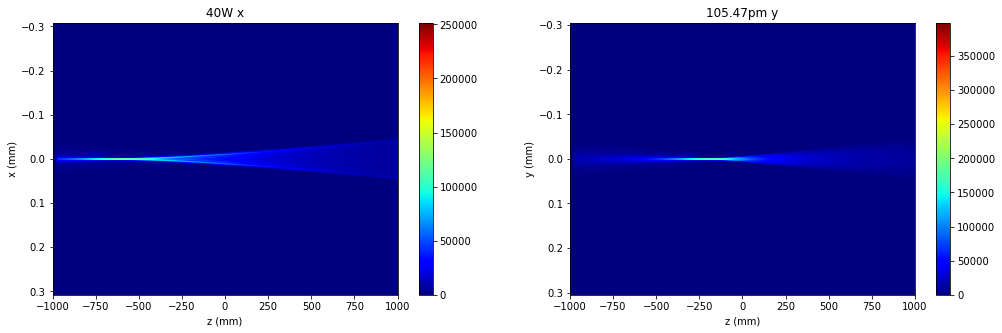

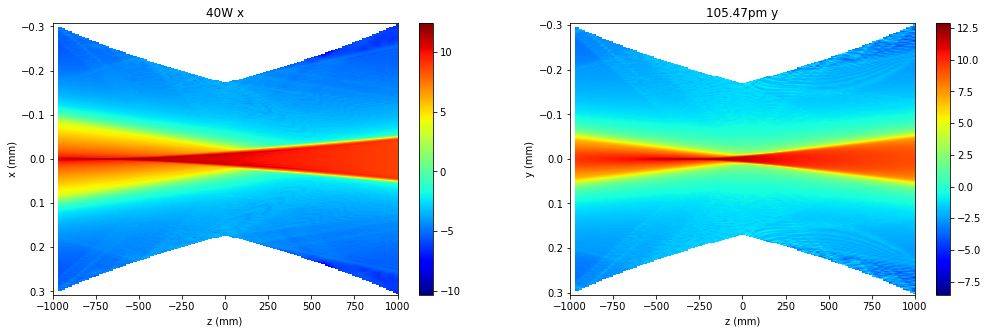

In [6]:
###### overview, linear
plt.figure(figsize=(17,5*n_img))
for i in range(n_img):
    img_x = slice_x[i].T; img_y = slice_y[i].T
    x = axis_x[i]*1e3; y = axis_y[i]*1e3; z = axis_z[i]*1e3
    
    plt.subplot(n_img,2,2*i+1)
    plt.imshow(img_x, cmap='jet',
              extent = [z.min(), z.max(), x.max(), x.min()])
    plt.xlabel('z (mm)'); plt.ylabel('x (mm)'); plt.title(powers[i]+' x'); plt.axis('tight'); plt.colorbar()
    plt.clim([0, np.max(slice_x)])
    
    plt.subplot(n_img,2,2*i+2)
    plt.imshow(img_y, cmap='jet',
              extent = [z.min(), z.max(), y.max(), y.min()])
    plt.xlabel('z (mm)'); plt.ylabel('y (mm)'); plt.title(labels[i]+' y'); plt.axis('tight'); plt.colorbar()
    plt.clim([0, np.max(slice_y)])
if n_img == 1:
    plt.savefig(dir_ev+'side_view_linear_{}.png'.format(fname_profile), transparent=True)
else:
    plt.savefig(dir_ev+'side_views_linear.png', transparent=True)

###### overview, log
plt.figure(figsize=(17,5*n_img))
for i in range(n_img):
    img_x = slice_x[i].T; img_y = slice_y[i].T
    x = axis_x[i]*1e3; y = axis_y[i]*1e3; z = axis_z[i]*1e3
    
    plt.subplot(n_img,2,2*i+1)
    plt.imshow(np.log(img_x), cmap='jet',
              extent = [z.min(), z.max(), x.max(), x.min()])
    plt.xlabel('z (mm)'); plt.ylabel('x (mm)'); plt.title(powers[i]+' x'); plt.axis('tight'); plt.colorbar()
    
    plt.subplot(n_img,2,2*i+2)
    plt.imshow(np.log(img_y), cmap='jet',
              extent = [z.min(), z.max(), y.max(), y.min()])
    plt.xlabel('z (mm)'); plt.ylabel('y (mm)'); plt.title(labels[i]+' y'); plt.axis('tight'); plt.colorbar()
if n_img == 1:
    plt.savefig(dir_ev+'side_view_log_{}.png'.format(fname_profile), transparent=True)
else:
    plt.savefig(dir_ev+'side_views_log.png', transparent=True)

105.47pm, focus max intensity, x: z=-580.0mm, y: z=-200.0mm


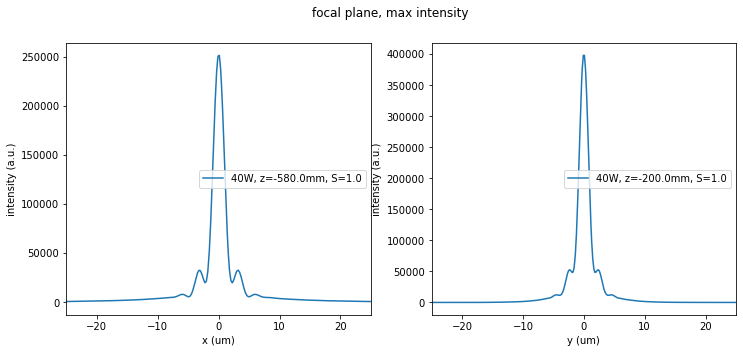

In [7]:
###### find focal plane using highest intensity
fig1 = plt.figure(figsize=(12,5))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

int_list_x = []
int_list_y = []

focus_x_max_intensity = []
focus_y_max_intensity = []

range_x = 50e-6
range_y = 50e-6

for i in range(n_img):
    # data
    x = axis_x[i]*1e6; y = axis_y[i]*1e6; z = axis_z[i]*1e3
    nx = x.size; ny = y.size; nz = z.size
    int_x = slice_x[i]; int_y = slice_y[i]; label1 = powers[i]; label2 = label1
    
    ## focal plane (maximum intensity)
#     index_x = np.argmax(int_x[:,np.abs(x)<=1].sum(axis=1))
#     index_y = np.argmax(int_y[:,np.abs(y)<=1].sum(axis=1))
    index_x = np.amax(int_x, axis=1).argmax()
    index_y = np.amax(int_y, axis=1).argmax()
    focus_x_max_intensity.append(index_x)
    focus_y_max_intensity.append(index_y)
    
    label1 += ', z={}mm'.format(round(z[focus_x_max_intensity][i],2))
    label2 += ', z={}mm'.format(round(z[focus_y_max_intensity][i],2))
    
    line_x = int_x[index_x]
    line_y = int_y[index_y]
    
    int_list_x.append(line_x.max())
    int_list_y.append(line_y.max())
    label1 += ', S={}'.format(round(int_list_x[i]/int_list_x[0],2))
    label2 += ', S={}'.format(round(int_list_y[i]/int_list_y[0],2))
    
    # plots
    ax1.plot(x, line_x, label=label1)
    ax2.plot(y, line_y, label=label2)

ax1.set_xlabel('x (um)')
ax1.set_ylabel('intensity (a.u.)')
ax1.legend()
ax1.set_xlim([-range_x/2*1e6, range_x/2*1e6])
# ax1.set_title('z={}mm'.format(round(z[focus_x_max_intensity][i],2))))

ax2.set_xlabel('y (um)')
ax2.set_ylabel('intensity (a.u.)')
ax2.legend()
ax2.set_xlim([-range_y/2*1e6, range_y/2*1e6])
# ax2.set_title('z={}mm'.format(round(z[focus_y_max_intensity][i],2)))

fig1.suptitle('focal plane, max intensity')

for i, name in enumerate(labels):
    print('{}, focus max intensity, x: z={}mm, y: z={}mm'.format(name, round(z[focus_x_max_intensity][i],2), round(z[focus_y_max_intensity][i],2)))
if n_img == 1:
    plt.savefig(dir_ev+'Strehl_Ratio_max_{}.png'.format(fname_profile), transparent=True)
else:
    plt.savefig(dir_ev+'Strehl_Ratios_max.png', transparent=True)

In [8]:
### target: 4 slices
# slice 1: thermal deformation shape; beam 1-fwhm on mirror
# slice 2: xz; yz plot
# slice 3: xy around focal plane -> intensity ratio
# slice 4: Strehl ratio vs intensity ratio -> engineering specs